In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/tmp/.fastai/data/camvid/images'),
 PosixPath('/tmp/.fastai/data/camvid/codes.txt'),
 PosixPath('/tmp/.fastai/data/camvid/labels'),
 PosixPath('/tmp/.fastai/data/camvid/valid.txt')]

In [4]:
path_label  = path/'labels' 
path_images = path/'images'

In [5]:
file_names = get_image_files(path_images)
file_names[:3]

[PosixPath('/tmp/.fastai/data/camvid/images/Seq05VD_f03240.png'),
 PosixPath('/tmp/.fastai/data/camvid/images/0006R0_f02100.png'),
 PosixPath('/tmp/.fastai/data/camvid/images/Seq05VD_f03180.png')]

In [6]:
file_lables = get_image_files(path_label)
file_lables[:3]

[PosixPath('/tmp/.fastai/data/camvid/labels/0016E5_04500_P.png'),
 PosixPath('/tmp/.fastai/data/camvid/labels/0006R0_f01650_P.png'),
 PosixPath('/tmp/.fastai/data/camvid/labels/0016E5_08133_P.png')]

In [7]:
import matplotlib.pyplot as plt
import cv2

In [8]:
image = cv2.imread('/tmp/.fastai/data/camvid/images/0016E5_00840.png')

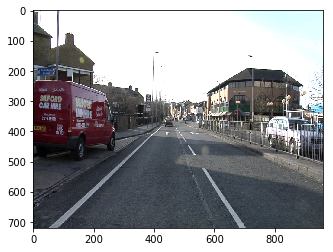

In [9]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

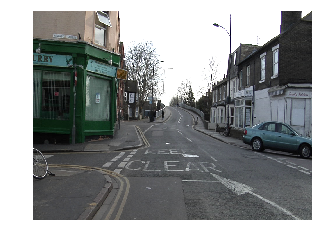

In [10]:
img_f = file_names[0]
img = open_image(img_f)
img.show(figsize=(5,5))

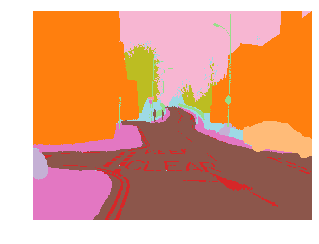

In [11]:
get_y_fn = lambda x: path_label/f'{x.stem}_P{x.suffix}'
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [13]:
src_size = np.array(mask.shape[1:])
src = (SegmentationItemList.from_folder(path_images)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), size=src_size, tfm_y=True)
        .databunch(bs=4)
        .normalize(imagenet_stats))

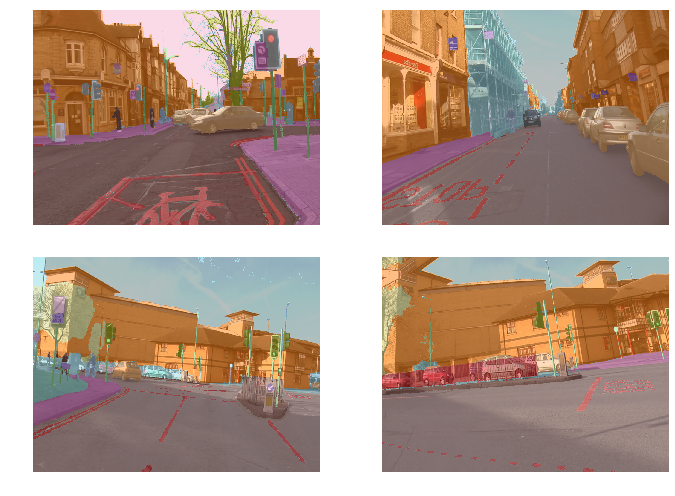

In [15]:
data.show_batch(2, figsize=(10,7))

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
metrics=acc_camvid

In [17]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=1e-2).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 82890271.56it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


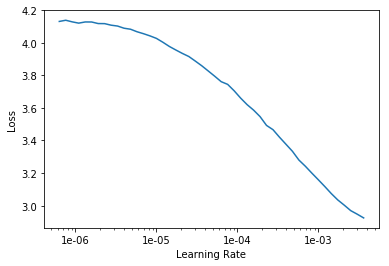

In [18]:
lr_find(learn)
learn.recorder.plot()

In [19]:
lr=1e-3; learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.108920,0.720246,0.817884,03:31
1,0.780018,0.647179,0.824935,03:54
2,0.629494,0.593311,0.823706,03:54
3,0.568404,0.451136,0.881246,03:54
4,0.564011,0.446272,0.869054,03:54
5,0.555973,0.421155,0.882808,03:54
6,0.505279,0.365571,0.891578,03:55
7,0.470273,0.330492,0.908712,03:54
8,0.419957,0.380876,0.885761,03:54
9,0.353420,0.300015,0.912559,03:54


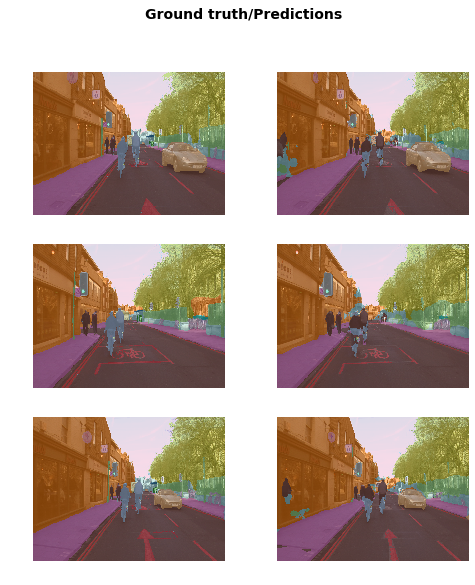

In [20]:
learn.save('stage-1')
learn.load('stage-1');
learn.show_results(rows=3, figsize=(8,9))

In [21]:
learn.unfreeze()
lrs = slice(1e-6,lr/10)
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.310221,0.291913,0.915289,04:02
1,0.298822,0.271863,0.921214,04:02
2,0.302254,0.280361,0.920092,04:02
3,0.283946,0.279006,0.920859,04:01
4,0.263605,0.291307,0.915856,04:02
5,0.254298,0.283470,0.917462,04:02
6,0.247842,0.258874,0.925142,04:02
7,0.239210,0.268816,0.922854,04:02
8,0.234425,0.261610,0.924505,04:01
9,0.232446,0.259395,0.925138,04:02


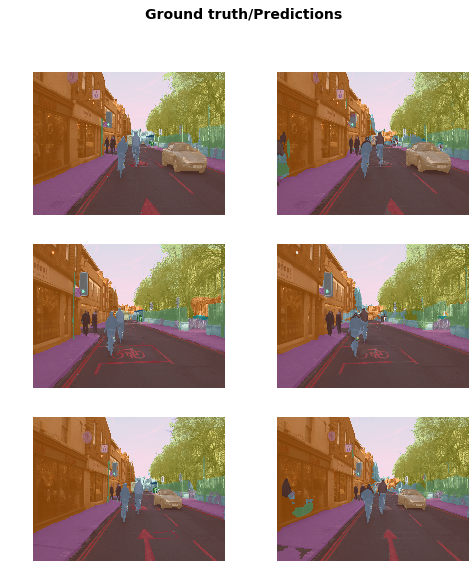

In [22]:
learn.show_results(rows=3, figsize=(8,9))